# Algoritmo Genético Aplicado Na Otimização de Reposição de Linhas

In [1]:
#from math import inf
#from mimetypes import init
#from operator import le
from Population import Population
from Selection import Selection
from Individuals import Individuals
from Cutpoint import Cutpoint
from Crossover import Crossover
from Mutation import Mutation
from Tournament import Tournament
from Fitness import Fitness
import numpy as np
import random
import matplotlib.pyplot as plt

## Modelagem da Função objetivo

In [2]:
def minimize(data):
    # Função de minimização
    return -((int(data, 2)/(2**30 - 1))**2)

In [3]:
random.seed(12345) # Para reproduzir o mesmo resultado

## Algoritmo Genético

In [4]:
Pc = 0.70  # probabilidade de crossover
Pm = 0.01  # probabilidade de mutação
Niter = 200

# Definindo a função fitness
fitness = Fitness(minimize)

# Gerando a população inicial e desempenho inicial
population = Population.generate(100, 30)
fitness = fitness.evaluate(population)

# Algoritmo Genético
iter = 0
fitness_history = {'iter': [], 'fitness': [], 'xmin': []}
while iter < Niter:
    #print(f'''iter: {iter}''')
    # Parametrizando operações do AG
    selection = Selection(population, Pc)
    tournament = Tournament(selection, fitness, population)
    crossover = Crossover(population, selection)

    # Atualizando a população(torneio, crossover e mutation)
    tournament = tournament.new_population
    crossover = crossover.new_population
    mutants = Mutation(Pm, crossover)
    mutants = mutants.new_population

    # Nova geração
    new_population = tournament + mutants
    fitness = fitness.evaluate(new_population)

    # Armazenando os dados
    fitness_iter = {'iter': iter, 'fitness': fitness.min, 'xmin': fitness.xmin}
    for key, value in fitness_iter.items():
        fitness_history[key].append(value)

    # proxima iteração
    population = new_population
    iter += 1

## Resultados

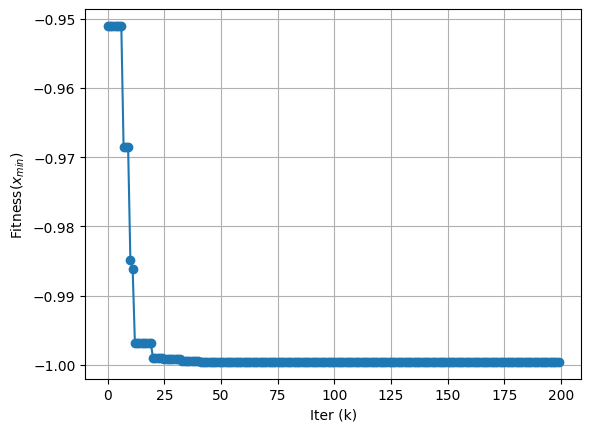

done


In [5]:
plt.figure()
plt.plot(fitness_history['iter'],fitness_history['fitness'],'-o')
plt.xlabel('Iter (k)')
plt.ylabel('Fitness($x_{min}$)')
plt.grid()
plt.show()
print('done')